In [1]:
import sys, os
sys.path.append("../model/")
sys.path.append("../datasets/")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from train import getprobs
from EvalTools import *
import numpy as np
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import mpl_scatter_density
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [5]:
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"
data_loc = '/scratch/bbuw/avroy/jet_tagging_datasets/datasets/'
dataset = 'jetnet'

all_models = [f for f in os.listdir(saved_model_loc) if "_best" in f and "_trial" not in f and dataset in f and 'softmax' not in f]
print("\n".join(all_models))

UQPFIN_best_jetnet_nominal_baseline
UQPFIN_best_jetnet_0_skiptwz
UQPFIN_best_jetnet_0.5_skiptwz_ocmodel
UQPFIN_best_jetnet_0.1_skiptop_ocmodel
UQPFIN_best_jetnet_nominal_baseline2
UQPFIN_best_jetnet_0_baseline
UQPFIN_best_jetnet_0.5_skiptop_ocmodel
UQPFIN_best_jetnet_0.1_skiptop
UQPFIN_best_jetnet_0.1_baseline_ocmodel
UQPFIN_best_jetnet_0_skiptop
UQPFIN_best_jetnet_0.1_skipwz
UQPFIN_best_jetnet_0_skipwz
UQPFIN_best_jetnet_nominal_skiptwz
UQPFIN_best_jetnet_0.5_skipwz_ocmodel
UQPFIN_best_jetnet_nominal_skipwz
UQPFIN_best_jetnet_0.1_skiptwz
UQPFIN_best_jetnet_nominal_skiptop
UQPFIN_best_jetnet_0.5_baseline_ocmodel
UQPFIN_best_jetnet_0.1_skipwz_ocmodel
UQPFIN_best_jetnet_0.1_baseline
UQPFIN_best_jetnet_0.1_skiptwz_ocmodel


In [10]:
if dataset == 'topdata':
    true_classes = [0, 1] # 0:QCD, 1:top
    names = ["background", "signal"]
if dataset == 'jetnet':
    true_classes = [0, 1, 2, 3, 4] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['light quarks', 'gluons', 'top quarks', 'W bosons', 'Z bosons']
if dataset == 'jetclass':
    true_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['l_QCD', 'l_Hbb', 'l_Hcc', 'l_Hgg', 'l_H4q', 'l_Hqql', 'l_Zqq', 'l_Wqq', 'l_Tbqq', 'l_Tbl']
if dataset == 'JNqgmerged':
    true_classes = [0, 1, 2, 3] # 0: g/q, 1:t, 2:w, 3:z
    names = ['QCD', 'top quarks', 'W bosons', 'Z bosons']

#Loading testing dataset
if dataset != 'jetclass':
    test_path = os.path.join(data_loc, dataset, "test.h5")
    #Loading testing dataset
    test_set = PFINDataset(test_path)
    testloader = DataLoader(test_set, shuffle=False, batch_size=512, num_workers=1, pin_memory=True, persistent_workers=True)
else:
    data_path = glob.glob(os.path.join(data_loc, "jetclass", "test_*.h5"))
    test_set = JetClassData(batch_size = 512)
    test_set.set_file_names(file_names = data_path)
    testloader = test_set.generate_data()

In [11]:
model2explore = all_models[0]
print(model2explore)

evaluator = PairwiseEvaluator(os.path.join(saved_model_loc, model2explore))

UQPFIN_best_jetnet_nominal_baseline


In [12]:
baseline_latents, baseline_labels, baseline_intfeat, baseline_presoftmax, baseline_preds, _, baseline_uncs = evaluator.evaluate(data_loader=testloader)

In [13]:
auc_baseline = roc_auc_score(baseline_labels[:], baseline_preds[:], multi_class='ovo')*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 93.7315%


In [14]:
N2track = 10

shifts = []
dLRPs = []

dAUC_matrix = torch.zeros(N2track, N2track).numpy()
dUNC_matrix = torch.zeros(N2track, N2track).numpy()

n_classes = baseline_preds.shape[1]
for k in range(n_classes):
    
    shift_matrix = torch.zeros(N2track, N2track).numpy()
    dLRP_matrix = torch.zeros(N2track, N2track).numpy()
    
    for i in range(N2track):
        for j in range(i+1):
            if k == 0:
                dAUC_matrix[i,j] = np.nan
                dUNC_matrix[i,j] = np.nan
                
            dLRP_matrix[i,j] = np.nan
            shift_matrix[i,j] = np.nan
    
    shifts.append(shift_matrix)
    dLRPs.append(dLRP_matrix)
    
    
for i in range(N2track-1):
    for j in range(i+1, N2track):
        if dataset == 'jetclass':
            testloader = test_set.generate_data()
            
        latents, labels, intfeat, presoftmax, preds, masked_track, uncs = evaluator.evaluate(data_loader=testloader, mask_index=(i,j))
        auc2 = roc_auc_score(baseline_labels[:], baseline_preds[:], multi_class='ovo')*100

        dAUC_matrix[i,j] = auc_baseline - auc2
        dUNC_matrix[i,j] = (baseline_uncs - uncs).mean()
        
        
        dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
        dresult = (baseline_preds - preds)
        dunc = (baseline_uncs - uncs)
        for k in range(n_classes):
            sig_indices = baseline_labels == k
            shifts[k][i,j] = removeOutliers(dresult[sig_indices, k]).mean()

            dLRPs[k][i,j] = removeOutliers(dsoftmax[sig_indices, k]).mean()


/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline

/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: divide by zero encountered in true_divide
  dsoftmax = np.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax)
/tmp/ipykernel_2556870/1247519456.py:40: RuntimeWarning: invalid value encountered in true_divide
  dsoftmax = np.abs((baseline

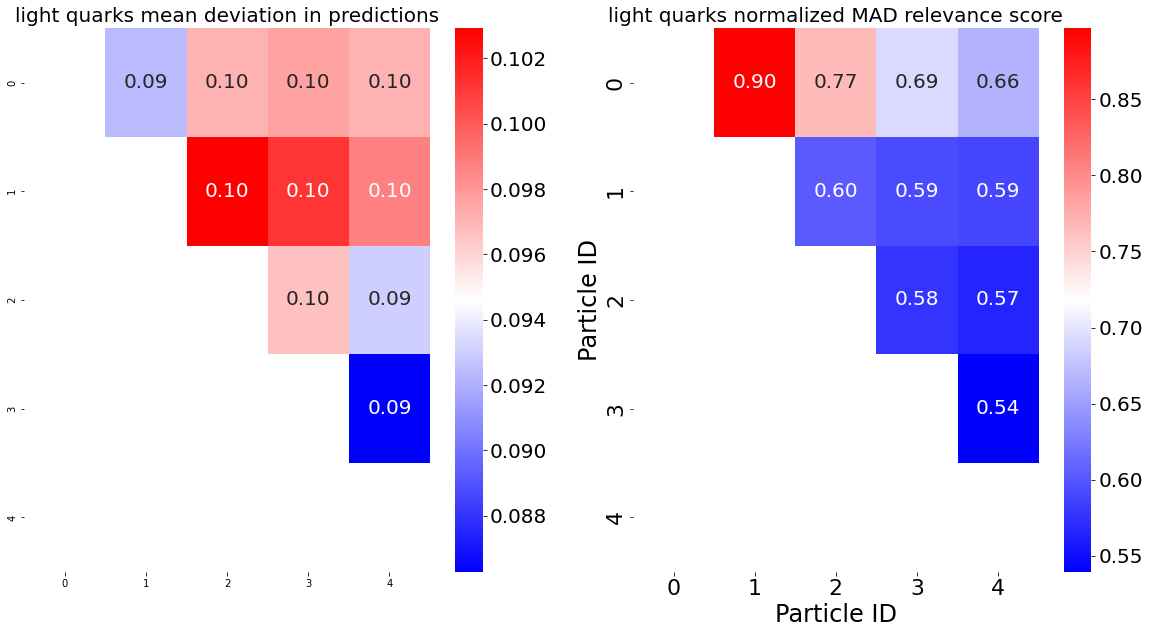

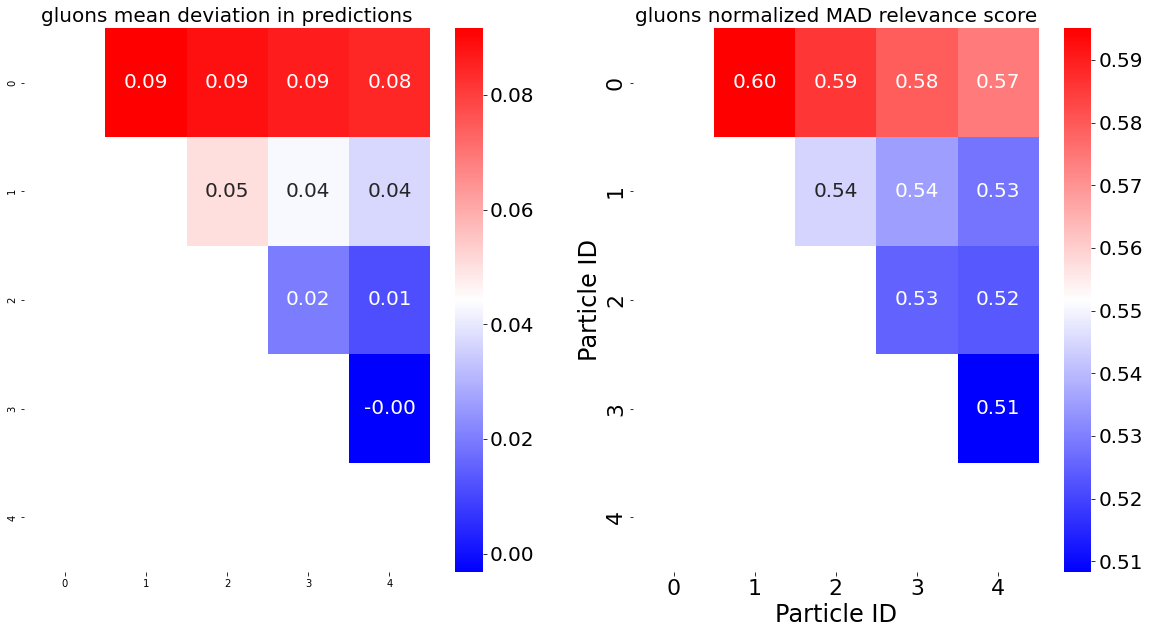

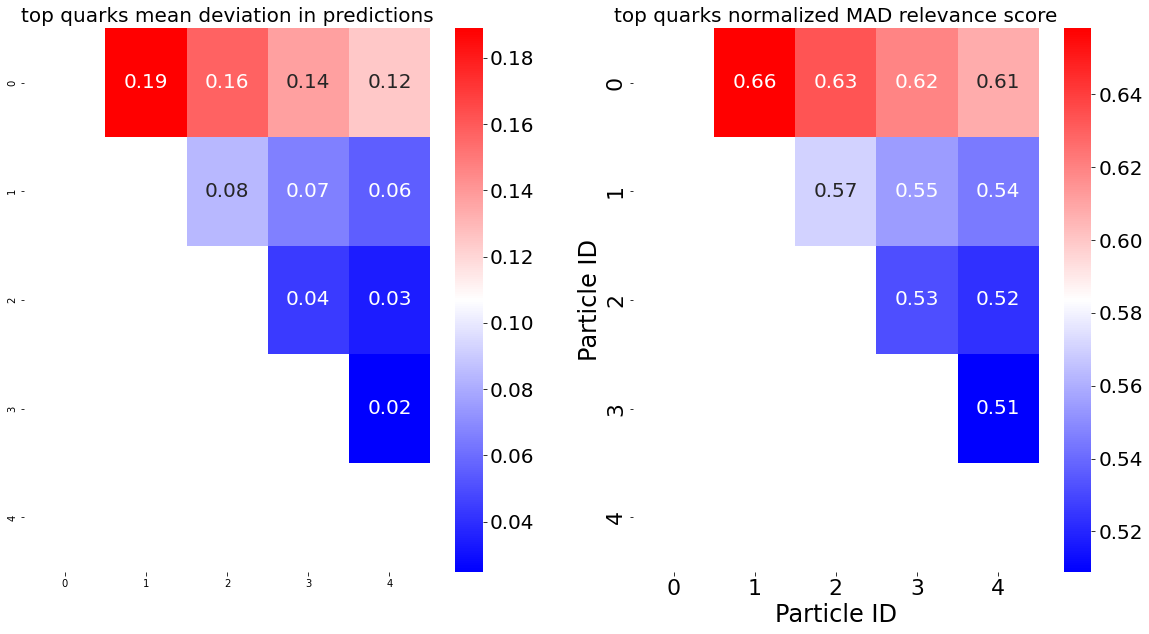

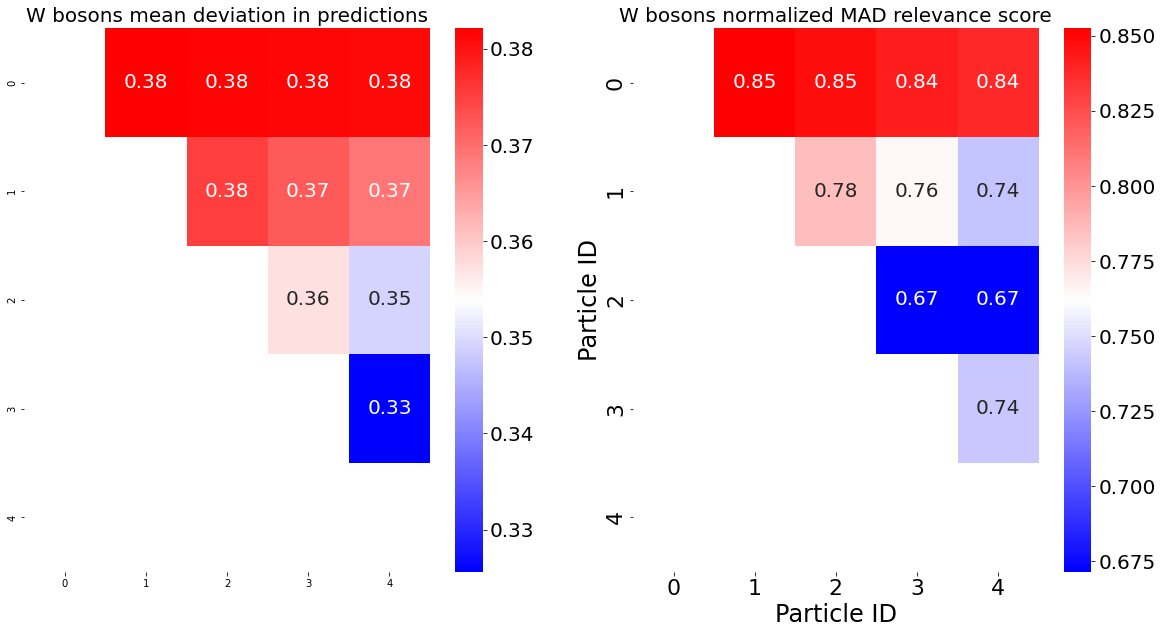

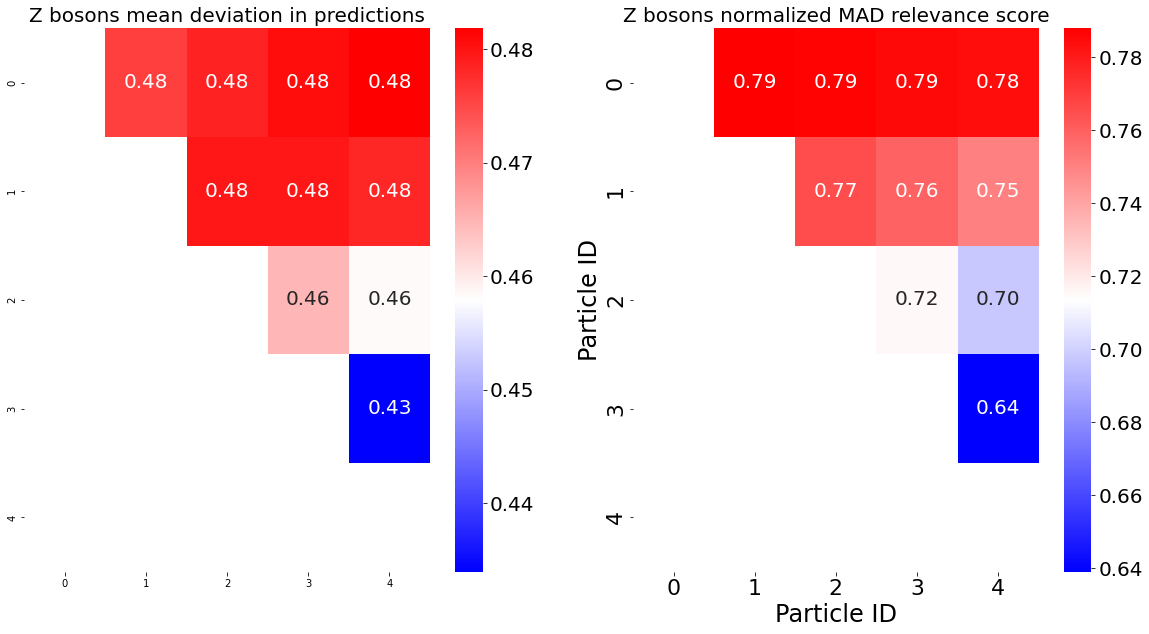

In [16]:
for k in range(n_classes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax = sns.heatmap(shifts[k][:N2track//2, :N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20}, ax=ax1)
    plt.tick_params(axis='both', which='major', labelsize=22)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.xlabel('Particle ID', fontsize=24)
    plt.ylabel('Particle ID', fontsize=24)
    label = evaluator.label
    
    ax = sns.heatmap(dLRPs[k][:N2track//2, :N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20}, ax=ax2)
    plt.tick_params(axis='both', which='major', labelsize=22)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.xlabel('Particle ID', fontsize=24)
    plt.ylabel('Particle ID', fontsize=24)
    
    ax1.set_title(names[k] + " mean deviation in predictions", fontsize=20)
    ax2.set_title(names[k] + " normalized MAD relevance score", fontsize=20)

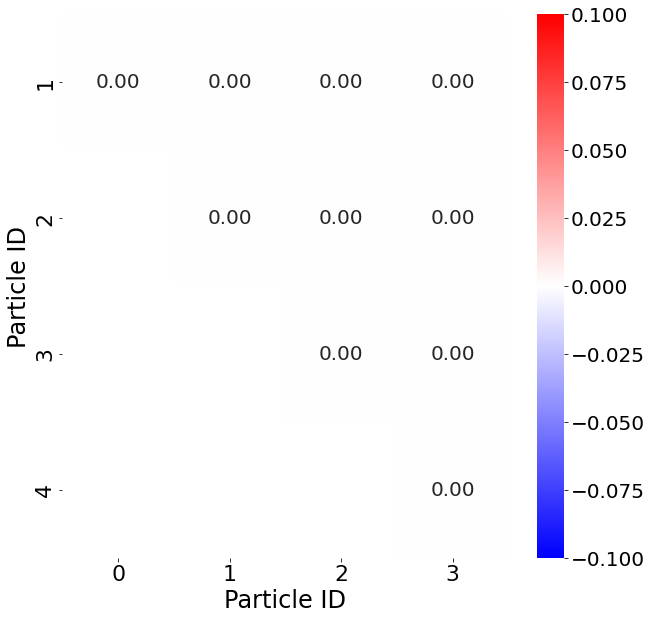

In [19]:
label = evaluator.label
plt.figure(figsize=(10,10))
xlabels = list(map(str, [i for i in range(1, N2track//2)]))
ylabels = list(map(str, [i for i in range(0, N2track//2 - 1)]))
ax = sns.heatmap(dAUC_matrix[:N2track//2-1, 1:N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20})
plt.yticks(np.arange(0,len(xlabels),1)+0.5, xlabels, fontsize=24)
plt.xticks(np.arange(0,len(ylabels),1)+0.5, ylabels, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Particle ID', fontsize=24)
plt.ylabel('Particle ID', fontsize=24)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
#plt.savefig("figures/dAUC_PFIN_{}.pdf".format(label))


Text(0.5, 1.0, 'Uncertainty Pairwise Interaction')

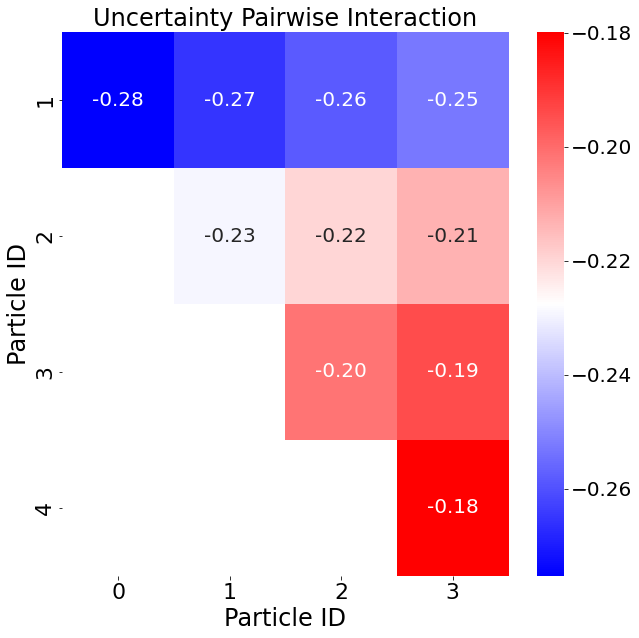

In [20]:
label = evaluator.label
plt.figure(figsize=(10,10))
xlabels = list(map(str, [i for i in range(1, N2track//2)]))
ylabels = list(map(str, [i for i in range(0, N2track//2 - 1)]))
ax = sns.heatmap(dUNC_matrix[:N2track//2-1, 1:N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20})
plt.yticks(np.arange(0,len(xlabels),1)+0.5, xlabels, fontsize=24)
plt.xticks(np.arange(0,len(ylabels),1)+0.5, ylabels, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Particle ID', fontsize=24)
plt.ylabel('Particle ID', fontsize=24)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title("Uncertainty Pairwise Interaction", fontsize=24)
#plt.savefig("figures/dAUC_PFIN_{}.pdf".format(label))
